In [1]:
# Import libraries
## for profiling
from profiler.main import profile

# for titiler-xarray
from typing import Any
import morecantile

# for titiler-pgstac
from titiler.pgstac.mosaic import PGSTACBackend
from typing import Any, Dict, List, Tuple
from rio_tiler.mosaic import mosaic_reader
from rio_tiler.models import ImageData
from geojson_pydantic import Polygon

# Only if wanting to see a picture
import io
from PIL import Image

In [2]:
import os
os.environ['AWS_PROFILE'] = 'veda-dev'

In [3]:
xyz_tile = (0,0,0)

## Profile titiler-pgstac

In [4]:
%load_ext autoreload
%autoreload
import pgstac.profile_pgstac as profile_pgstac 

### We can also run profiling via tile bench

In [5]:
#!pip install tilebench
#!tilebench profile s3://climatedashboard-data/cmip6/monthly/CMIP6_ensemble_median/tas/tas_month_ensemble-median_historical_195004.tif \
#    --tile 0-0-0 --add-cprofile --add-stdout --config GDAL_DISABLE_READDIR_ON_OPEN=EMPTY_DIR --config CPL_TIMESTAMP=ON | jq

In [11]:
query = {
  "collections": [
    "CMIP6_ensemble_median_TAS"
  ],
  "filter": {
    "op": "t_intersects",
    "args": [
      {
        "property": "datetime"
      },
      {
        "interval": [
          "1950-04-01T00:00:00Z",
          #"1950-05-01T00:00:00Z"
        ]
      }
    ]
  },
  "filter-lang": "cql2-json"
}

image_and_assets, cprofile = profile_pgstac.tile(*xyz_tile, query=dict(query))
cprofile

time calculating vrt_params: 1.09
time initiating WarpedVRT: 394.2
time reading WarpedVRT: 20.62
time creating ImageData: 0.02
time for reader.part: 417.04
{'pgstac-search': 70.09, 'get_tile': [2533.81], 'mosaic': 2536.29}


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "        9    2.534    0.282    2.534    0.282 {method 'acquire' of '_thread.lock' objects}",
  '        4    0.084    0.021    0.085    0.021 connection.py:949(wait)',
  '        2    0.001    0.000    0.001    0.000 core.py:3433(__setmask__)']}

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float64` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(


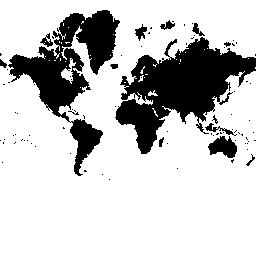

In [7]:
content = image_and_assets[0].render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im

## Profile titiler-xarray

In [8]:
%load_ext autoreload
%autoreload
import xarray_tile_reader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
image_and_assets, cprofile = xarray_tile_reader.tile(
    "cmip6-reference/combined_cmip6_kerchunk.json", 
    *xyz_tile,
    reference=True,
    anon=False,
    variable="tas",
)
cprofile

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/zarr_reader.py:40: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  ds = xarray.open_dataset(src_path, **xr_open_args)


Time elapsed for xarray.open_datset: 1131.56
Time elapsed for dimension arrangement and array pre-processing: 21.73
Time elapsed for clipping data via rasterio: 17.60101
IN REPROJECT
Time elapsed for reproject: 585.54316
Time elapsed for creating ImageData: 0.25702


{'cprofile': ['   ncalls  tottime  percall  cumtime  percall filename:lineno(function)',
  "       99    1.546    0.016    1.546    0.016 {method 'acquire' of '_thread.lock' objects}",
  "      161    0.047    0.000    0.047    0.000 {method 'read' of '_io.BufferedReader' objects}",
  '    19/17    0.027    0.001    0.029    0.002 {built-in method _imp.create_dynamic}',
  '      160    0.017    0.000    0.017    0.000 {built-in method marshal.loads}',
  '      770    0.012    0.000    0.012    0.000 {built-in method posix.stat}',
  '        4    0.010    0.002    0.023    0.006 core.py:1865(_process_chunk)',
  '      157    0.010    0.000    0.010    0.000 {built-in method builtins.compile}',
  '        1    0.009    0.009    0.009    0.009 {built-in method zlib.decompress}',
  '    65792    0.009    0.000    0.009    0.000 http_websocket.py:124(<genexpr>)',
  '        1    0.008    0.008    0.009    0.009 {rasterio._warp._reproject}',
  '      160    0.008    0.000    0.008    0.000 {

/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:648: InvalidDatatypeWarning: Invalid type: `float32` for the `PNG` driver. Data will be rescaled using min/max type bounds or dataset_statistics.
  warnings.warn(
/Users/aimeebarciauskas/github/developmentseed/tile-benchmarking/profiling/venv-profiling/lib/python3.9/site-packages/rio_tiler/models.py:140: RuntimeWarning: invalid value encountered in cast
  return data.astype(out_dtype)


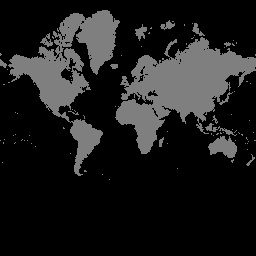

In [10]:
content = image_and_assets.render(
    img_format='PNG'
)

im = Image.open(io.BytesIO(content))
im